<a href="https://colab.research.google.com/github/sociallight0/AI-Tools-and-Applications/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch [100/500], Train Loss: 7761.4136, Test Loss: 8907.2090
Epoch [200/500], Train Loss: 3047.7256, Test Loss: 3573.9795
Epoch [300/500], Train Loss: 1107.2937, Test Loss: 1320.4073
Epoch [400/500], Train Loss: 487.0178, Test Loss: 595.8524
Epoch [500/500], Train Loss: 266.9749, Test Loss: 332.1071

Test MSE: 332.1072 tons/hectare^2
Predicted yield: 478.02 tons/hectare


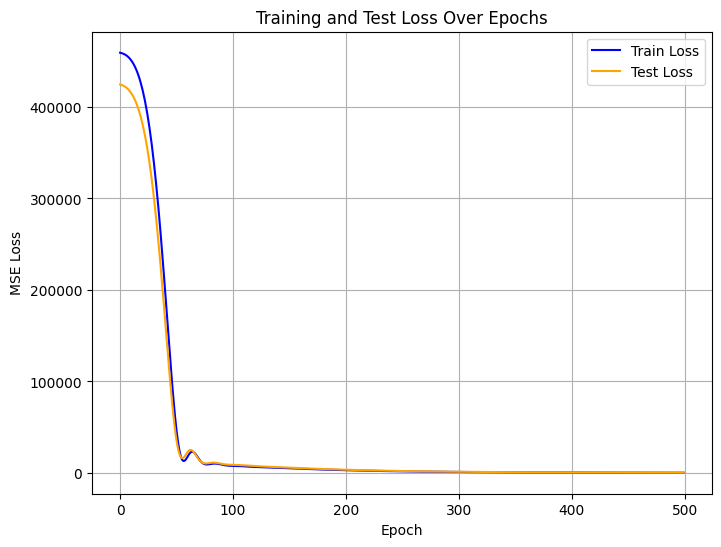

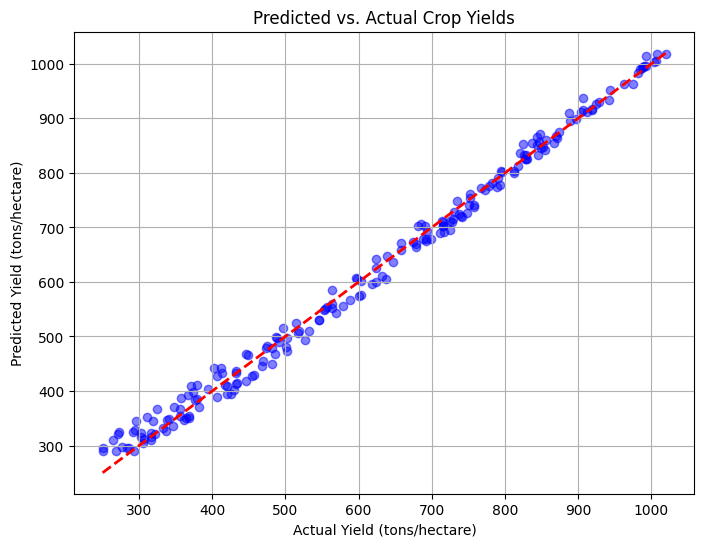

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Generate synthetic data (replace with real dataset, e.g., Kaggle)
num_samples = 1000
temperature = np.random.uniform(15, 35, num_samples)  # degrees C
rainfall = np.random.uniform(500, 2000, num_samples)  # mm/year
pesticides = np.random.uniform(0, 50, num_samples)  # tons
yield_true = 10 + 0.5 * rainfall - 0.2 * (temperature - 25)**2 + 0.1 * pesticides + np.random.normal(0, 5, num_samples)

# Prepare features
features = np.column_stack((temperature, rainfall, pesticides))

# Split data
X_train, X_test, y_train, y_test = train_test_split(features, yield_true, test_size=0.2, random_state=42)

# Normalize features using Scikit-learn
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Define neural network
class YieldPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3, 64)  # Input to hidden
        self.fc2 = nn.Linear(64, 32)  # Hidden to hidden
        self.fc3 = nn.Linear(32, 1)   # Hidden to output

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Instantiate model, loss, optimizer
model = YieldPredictor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 500
train_losses = []
test_losses = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor).item()
        test_losses.append(test_loss)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}')

# Final evaluation
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor).numpy().flatten()
mse = mean_squared_error(y_test, y_pred_test)
print(f'\nTest MSE: {mse:.4f} tons/hectare^2')

# Example prediction
sample_features = np.array([[25, 1000, 20]])  # Temp=25°C, Rain=1000mm, Pest=20 tons
sample_scaled = scaler.transform(sample_features)
sample_tensor = torch.tensor(sample_scaled, dtype=torch.float32)
predicted_yield = model(sample_tensor).item()
print(f'Predicted yield: {predicted_yield:.2f} tons/hectare')

# Plot 1: Training and Test Loss
plt.figure(figsize=(8, 6))
plt.plot(range(epochs), train_losses, label='Train Loss', color='blue')
plt.plot(range(epochs), test_losses, label='Test Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')
plt.show()

# Plot 2: Predicted vs. Actual Yields
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Yield (tons/hectare)')
plt.ylabel('Predicted Yield (tons/hectare)')
plt.title('Predicted vs. Actual Crop Yields')
plt.grid(True)
plt.savefig('yield_plot.png')
plt.show()